# Core

In [ ]:
# default_exp core

In [ ]:
#hide
from nbdev.showdoc import *
! pip install -Ue .

Obtaining file:///D:/Repositories/progressive-samplers
  Attempting uninstall: prosamplers
    Found existing installation: prosamplers 0.0.77
    Uninstalling prosamplers-0.0.77:
      Successfully uninstalled prosamplers-0.0.77
  Running setup.py develop for prosamplers


# Imports

In [ ]:
#export
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
#export
plt.style.use("bmh")
plt.rcParams["figure.figsize"] = (10, 10)

# GridSearch

In [ ]:
#export
def grid_search(x_range, y_range, n=10):
    visited = set()
    iteration = 0
    
    while True:
        divisions = 2 ** iteration + 1
        x = np.linspace(*x_range, divisions)
        y = np.linspace(*y_range, divisions)[::-1]
        mesh = np.array(np.meshgrid(x, y))
        mesh_reshaped = mesh.reshape(2, divisions**2).T

        for point in mesh_reshaped:
            point_tuple = tuple(point)
            if point_tuple not in visited:
                visited.add(point_tuple)
                yield point

            if len(visited) == n:
                return
        
        iteration += 1

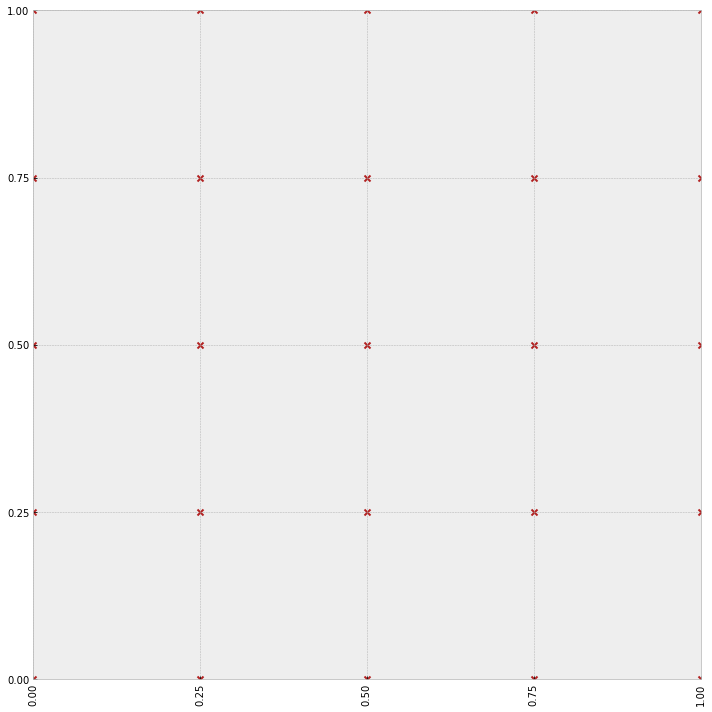

In [ ]:
n = 25
x_range = (0, 1)
y_range = (0, 1)
for point in grid_search(x_range, y_range, n):
    plt.scatter(*point, color="firebrick", marker="x")

plt.xticks(np.linspace(*x_range, int(n**0.5)), rotation=90)
plt.yticks(np.linspace(*y_range, int(n**0.5)))
    
plt.xlim(*x_range)
plt.ylim(*y_range)

plt.tight_layout()
plt.show()

In [ ]:
#export test
def test_grid_search_first_entries():
    from prosamplers.core import grid_search
    generator = grid_search(x_range=[0, 1], y_range=[0, 1])
    assert list(next(generator)) == [0.0, 1.0]
    assert list(next(generator)) == [1.0, 1.0]
    assert list(next(generator)) == [0.0, 0.0]
    assert list(next(generator)) == [1.0, 0.0]
    assert list(next(generator)) == [0.5, 1.0]
    
    
def test_grid_search_default_n():
    from prosamplers.core import grid_search
    assert list(grid_search(x_range=[0, 1], y_range=[0, 1]))

    
def test_grid_search_default_load_test():
    from prosamplers.core import grid_search
    from collections import deque
    
    deque(grid_search(x_range=[0, 1], y_range=[0, 1], n=1000), maxlen=0)
    assert True

# Random Search

In [ ]:
#export
def random_search(x_range, y_range, n=10, seed=42):
    
    RNG = np.random.default_rng(seed)
    
    xs, ys = RNG.uniform(0, 1, size=(n, 2)).T

    x_lower, x_upper = x_range
    xs = xs * (x_upper - x_lower) + x_lower

    y_lower, y_upper = y_range
    ys = ys * (y_upper - y_lower) + y_lower

    for point in zip(xs, ys):
        yield point

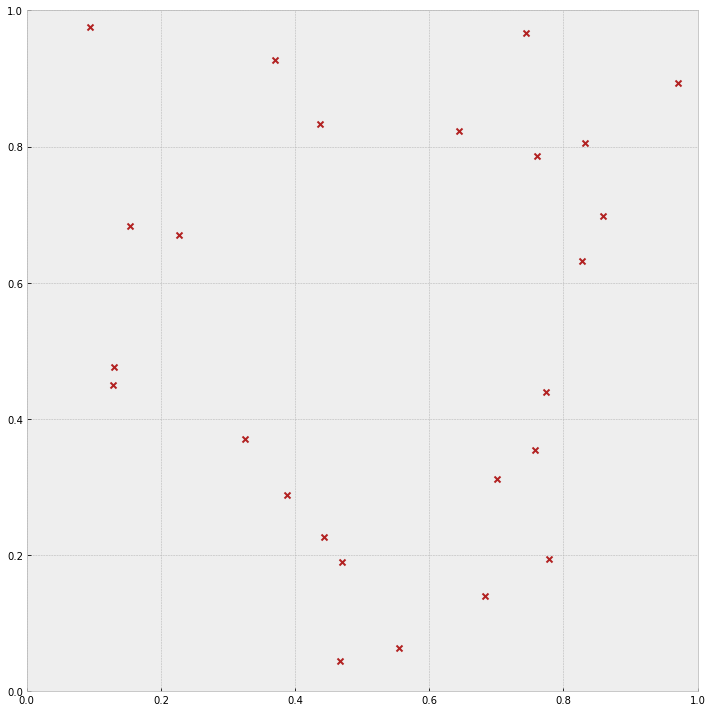

In [ ]:
n = 25
x_range = (0, 1)
y_range = (0, 1)
for point in random_search(x_range, y_range, n):
    plt.scatter(*point, color="firebrick", marker="x")

plt.xlim(*x_range)
plt.ylim(*y_range)

plt.tight_layout()
plt.show()

In [ ]:
#export test
def test_random_search_with_seed():
    from prosamplers.core import random_search
    import numpy as np
    generator = random_search(x_range=[0, 1], y_range=[0, 1], seed=42)
    assert list(np.round(next(generator), 2)) == [0.77, 0.44]
    assert list(np.round(next(generator), 2)) == [0.86, 0.7]
    assert list(np.round(next(generator), 2)) == [0.09, 0.98]
    assert list(np.round(next(generator), 2)) == [0.76, 0.79]
    assert list(np.round(next(generator), 2)) == [0.13, 0.45]
    

def test_random_search_default_n():
    from prosamplers.core import random_search
    assert list(random_search(x_range=[0, 1], y_range=[0, 1]))

    
def test_random_search_default_load_test():
    from prosamplers.core import random_search
    from collections import deque
    
    deque(random_search(x_range=[0, 1], y_range=[0, 1], n=1000), maxlen=0)
    assert True

# Latin HyperCube

In [ ]:
#export
def latin_hyper_cube(x_range, y_range, n=10, seed=42):
    x_lower, x_upper = x_range
    y_lower, y_upper = y_range
    
    
    visited = set()
    iteration = 0
    RNG_x = np.random.default_rng(seed)
    RNG_y = np.random.default_rng(seed+1)
    RNG_shuffler = np.random.default_rng(seed+2)
    RNG_init = np.random.default_rng(seed)

    divisions = 2

    limits = np.linspace(0, 1, divisions+1)
    lower_limits = limits[:-1]
    upper_limits = limits[1:]

    xs, ys = zip(*RNG_init.uniform(low=lower_limits, high=upper_limits, size=(2, divisions)).T)

    xs = np.array(xs)
    ys = np.array(ys)

    RNG_shuffler.shuffle(ys)

    for point in zip(xs, ys):
        visited.add(tuple(point))
        x_scale = point[0] * (x_upper - x_lower) + x_lower
        y_scale = point[1] * (y_upper - y_lower) + y_lower
        yield (x_scale, y_scale)
        
        if len(visited) >= n:
            return

    while True:
        divisions *= 2

        limits = np.linspace(0, 1, divisions+1)
        lower_limits = limits[:-1]
        upper_limits = limits[1:]

        indexes_empty_x = []
        indexes_empty_y = []

        for index, (lower, upper) in enumerate(zip(lower_limits, upper_limits)):
            is_occupied_x = any(lower < point[0] < upper for point in visited)
            indexes_empty_x.append(is_occupied_x)

            is_occupied_y = any(lower < point[1] < upper for point in visited)
            indexes_empty_y.append(is_occupied_y)

        indexes_empty_x = np.array(indexes_empty_x)
        indexes_empty_y = np.array(indexes_empty_y)

        xs = RNG_x.uniform(low=lower_limits[~indexes_empty_x], high=upper_limits[~indexes_empty_x])
        ys = RNG_y.uniform(low=lower_limits[~indexes_empty_y], high=upper_limits[~indexes_empty_y])
        RNG_shuffler.shuffle(ys)

        for point in zip(xs, ys):
            visited.add(tuple(point))
            x_scale = point[0] * (x_upper - x_lower) + x_lower
            y_scale = point[1] * (y_upper - y_lower) + y_lower
            yield (x_scale, y_scale)
        
            if len(visited) >= n:
                return

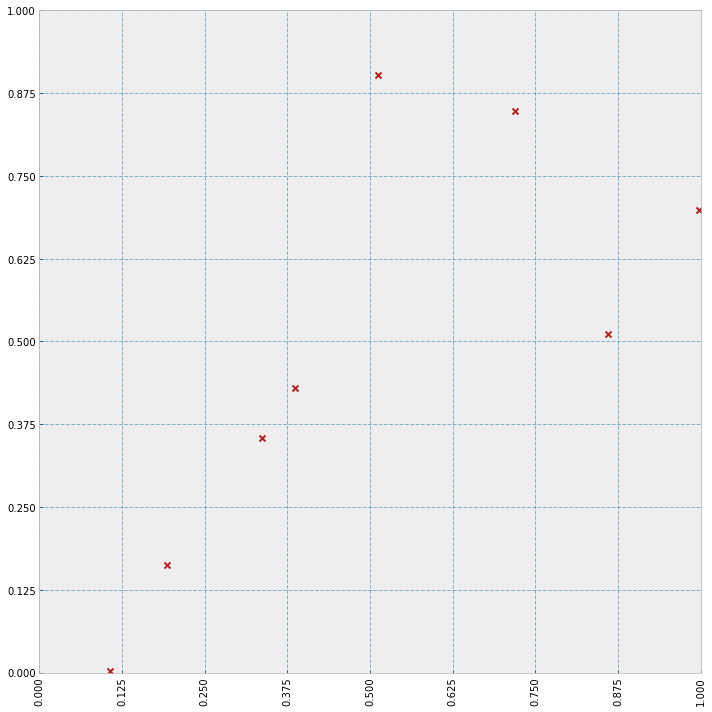

In [ ]:
n = 8
x_range = (0, 1)
y_range = (0, 1)

for point in latin_hyper_cube(x_range, y_range, n):
    plt.scatter(*point, color="firebrick", marker="x")

plt.xlim(*x_range)
plt.ylim(*y_range)

divisions = 2**(n-1).bit_length() + 1

for i in np.linspace(*x_range, divisions):
    plt.axvline(i, alpha=0.6, ls="--", lw=1)

for i in np.linspace(*y_range, divisions):
    plt.axhline(i, alpha=0.6, ls="--", lw=1)

plt.xticks(np.linspace(*x_range, divisions), rotation=90)
plt.yticks(np.linspace(*y_range, divisions))

plt.grid()
plt.tight_layout()
plt.show()

In [ ]:
#export test
def test_latin_hyper_cube_with_seed():
    from prosamplers.core import latin_hyper_cube
    import numpy as np
    generator = latin_hyper_cube(x_range=[0, 1], y_range=[0, 1], seed=42)
    assert list(np.round(next(generator), 2)) == [0.39, 0.43]
    assert list(np.round(next(generator), 2)) == [0.72, 0.85]
    assert list(np.round(next(generator), 2)) == [0.19, 0.16]
    assert list(np.round(next(generator), 2)) == [0.86, 0.51]
    assert list(np.round(next(generator), 2)) == [0.11, 0.  ]

    
def test_latin_hyper_cube_default_n():
    from prosamplers.core import latin_hyper_cube
    assert list(latin_hyper_cube(x_range=[0, 1], y_range=[0, 1]))

    
def test_latin_hyper_cube_default_load_test():
    from prosamplers.core import latin_hyper_cube
    from collections import deque
    
    deque(latin_hyper_cube(x_range=[0, 1], y_range=[0, 1], n=1000), maxlen=0)
    assert True

# Orthogonal sampling

# Stratified sampling (Jittered Sampling)
https://www.scratchapixel.com/lessons/mathematics-physics-for-computer-graphics/monte-carlo-methods-in-practice/introduction-quasi-monte-carlo

In [ ]:
#export
def jittered_sampling(x_range, y_range, n=10, seed=42):
    x_lower, x_upper = x_range
    y_lower, y_upper = y_range

    visited = set()
    iteration = 0
    RNG_x = np.random.default_rng(seed)
    RNG_y = np.random.default_rng(seed+1)
    RNG_shuffler = np.random.default_rng(seed+2)
    RNG_init = np.random.default_rng(seed)

    divisions = 2

    limits = np.linspace(0, 1, divisions+1)
    lower_limits, upper_limits = limits[:-1], limits[1:]

    for lower_x, upper_x in zip(lower_limits, upper_limits):
        for lower_y, upper_y in zip(lower_limits, upper_limits):
            x = RNG_x.uniform(low=lower_x, high=upper_x)
            y = RNG_y.uniform(low=lower_y, high=upper_y)
            point = (x, y)
            visited.add(point)
            x_scale = x * (x_upper - x_lower) + x_lower
            y_scale = y * (y_upper - y_lower) + y_lower
            yield (x_scale, y_scale)

            if len(visited) >= n:
                return

    while True:
        divisions *= 2

        limits = np.linspace(0, 1, divisions+1)
        lower_limits, upper_limits = limits[:-1], limits[1:]

        for lower_x, upper_x in zip(lower_limits, upper_limits):
            for lower_y, upper_y in zip(lower_limits, upper_limits):
                empty = not any(lower_x < point[0] < upper_x and lower_y < point[1] < upper_y for point in visited)
                if empty:
                    x = RNG_x.uniform(low=lower_x, high=upper_x)
                    y = RNG_y.uniform(low=lower_y, high=upper_y)
                    point = (x, y)
                    visited.add(point)
                    x_scale = x * (x_upper - x_lower) + x_lower
                    y_scale = y * (y_upper - y_lower) + y_lower
                    yield (x_scale, y_scale)

                if len(visited) >= n:
                    return

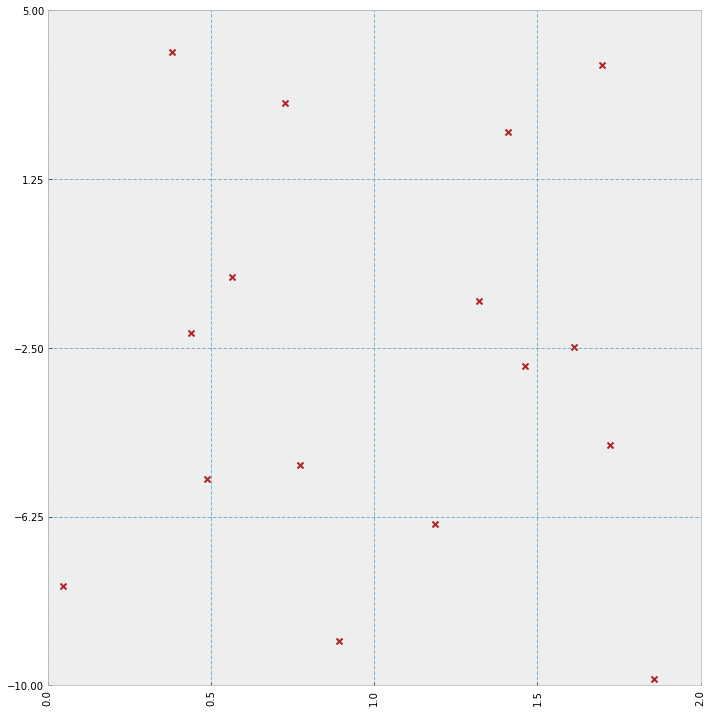

In [ ]:
n = 16
x_range = (0, 2)
y_range = (-10, 5)
for point in jittered_sampling(x_range, y_range, n):
    plt.scatter(*point, color="firebrick", marker="x")

plt.xlim(*x_range)
plt.ylim(*y_range)

divisions = int(2**np.ceil(np.log(n) / np.log(4)) + 1)

for i in np.linspace(*x_range, divisions):
    plt.axvline(i, alpha=0.6, ls="--", lw=1)

for i in np.linspace(*y_range, divisions):
    plt.axhline(i, alpha=0.6, ls="--", lw=1)

plt.xticks(np.linspace(*x_range, divisions), rotation=90)
plt.yticks(np.linspace(*y_range, divisions))

plt.grid()
plt.tight_layout()
plt.show()

In [ ]:
#export test
def test_jittered_sampling_with_seed():
    from prosamplers.core import jittered_sampling
    import numpy as np
    generator = jittered_sampling(x_range=[0, 1], y_range=[0, 1], seed=42)
    assert list(np.round(next(generator), 2)) == [0.39, 0.33]
    assert list(np.round(next(generator), 2)) == [0.22, 0.52]
    assert list(np.round(next(generator), 2)) == [0.93, 0.01]
    assert list(np.round(next(generator), 2)) == [0.85, 0.92]
    assert list(np.round(next(generator), 2)) == [0.02, 0.15]

    
def test_jittered_sampling_default_n():
    from prosamplers.core import jittered_sampling
    assert list(jittered_sampling(x_range=[0, 1], y_range=[0, 1]))

    
def test_jittered_sampling_default_load_test():
    from prosamplers.core import jittered_sampling
    from collections import deque
    
    deque(jittered_sampling(x_range=[0, 1], y_range=[0, 1], n=1000), maxlen=0)
    assert True

# Multi-Jittered sampling

In [ ]:
# resolution_x, resolution_y = (4, 4)
# cells = resolution_x * resolution_y

# xs_ = np.linspace(0, 1, resolution_x, endpoint=False)
# ys_ = np.linspace(0, 1, resolution_y, endpoint=False)

# xs, ys = np.meshgrid(xs_, ys_)

# xs = (xs.T + ys_ / resolution_x).T
# ys = ys + xs_ / resolution_y

# xs += np.random.rand(*xs.shape) / cells
# ys += np.random.rand(*ys.shape) / cells

# np.random.shuffle(xs.T)
# np.random.shuffle(ys)

# plt.scatter(xs, ys)

# plt.xlim(0, 1)
# plt.ylim(0, 1)

# for x in xs_:
#     plt.axvline(x, ls="--", alpha=0.6)

# for y in ys_:
#     plt.axhline(y, ls="--", alpha=0.6)
    
# plt.xticks(np.linspace(0, 1, resolution_x**2 + 1))
# plt.yticks(np.linspace(0, 1, resolution_y**2 + 1))
# plt.show()

In [ ]:
#export
def multi_jittered(x_range, y_range, n=10, seed=42):
    x_lower, x_upper = x_range
    y_lower, y_upper = y_range
    
    RNG_x = np.random.default_rng(seed)
    RNG_y = np.random.default_rng(seed+1)
    RNG_shuffler_x = np.random.default_rng(seed+2)
    RNG_shuffler_y = np.random.default_rng(seed+3)
    
    side = int(n ** 0.5 + 0.5)
    resolution_x, resolution_y = (side, side)
    cells = resolution_x * resolution_y

    xs_ = np.linspace(0, 1, resolution_x, endpoint=False)
    ys_ = np.linspace(0, 1, resolution_y, endpoint=False)

    xs, ys = np.meshgrid(xs_, ys_)

    xs = (xs.T + ys_ / resolution_x).T
    ys = ys + xs_ / resolution_y

    xs += RNG_x.random(size=xs.shape) / cells
    ys += RNG_y.random(size=ys.shape) / cells

    RNG_shuffler_x.shuffle(xs.T)
    RNG_shuffler_y.shuffle(ys)

    xs_flat = np.ndarray.flatten(xs)
    ys_flat = np.ndarray.flatten(ys)
    
    points = 0
    
    for x, y in zip(xs_flat, ys_flat):
        x_scale = x * (x_upper - x_lower) + x_lower
        y_scale = y * (y_upper - y_lower) + y_lower
        yield (x_scale, y_scale)
        points += 1
        if points >= n:
            return

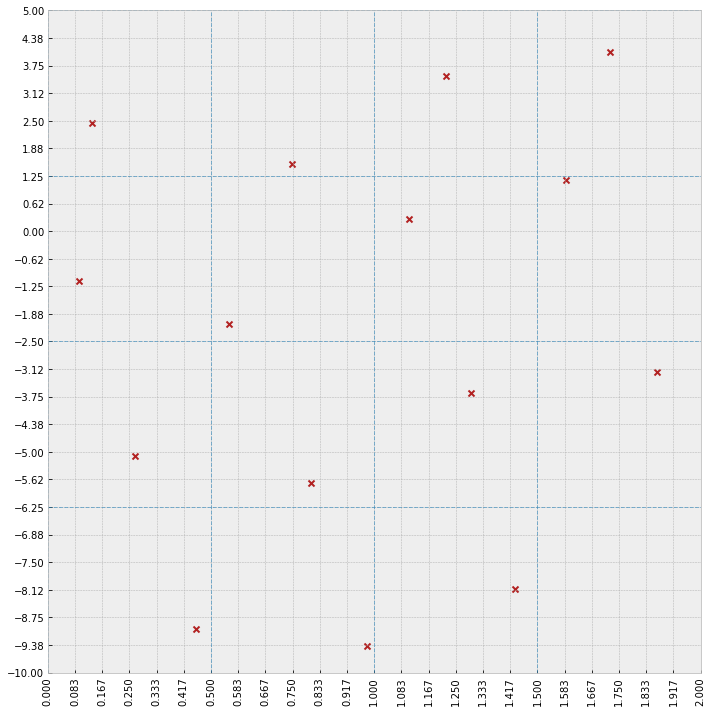

In [ ]:
n = 15
x_range = (0, 2)
y_range = (-10, 5)

for point in multi_jittered(x_range, y_range, n):
    plt.scatter(*point, color="firebrick", marker="x")

    
plt.xlim(*x_range)
plt.ylim(*y_range)

divisions = int(n ** 0.5+2)

for i in np.linspace(*x_range, divisions):
    plt.axvline(i, alpha=0.6, ls="--", lw=1)

for i in np.linspace(*y_range, divisions):
    plt.axhline(i, alpha=0.6, ls="--", lw=1)

plt.xticks(np.linspace(*x_range, divisions**2), rotation=90)
plt.yticks(np.linspace(*y_range, divisions**2))

# plt.grid()
plt.tight_layout()
plt.show()

In [ ]:
#export test
def test_multi_jittered_with_seed():
    from prosamplers.core import multi_jittered
    import numpy as np
    generator = multi_jittered(x_range=[0, 1], y_range=[0, 1], seed=42)
    assert list(np.round(next(generator), 2)) == [0.38, 0.75]
    assert list(np.round(next(generator), 2)) == [0.09, 0.81]
    assert list(np.round(next(generator), 2)) == [0.76, 0.94]
    assert list(np.round(next(generator), 2)) == [0.45, 0.43]
    assert list(np.round(next(generator), 2)) == [0.19, 0.51]

    
def test_multi_jittered_default_n():
    from prosamplers.core import multi_jittered
    assert list(multi_jittered(x_range=[0, 1], y_range=[0, 1]))

    
def test_multi_jittered_default_load_test():
    from prosamplers.core import multi_jittered
    from collections import deque
    
    deque(multi_jittered(x_range=[0, 1], y_range=[0, 1], n=1000), maxlen=0)
    assert True

# Poisson-Disk Sampling (Blue-Noise Sampling)

- https://www.cs.ubc.ca/~rbridson/docs/bridson-siggraph07-poissondisk.pdf
- https://www.youtube.com/watch?v=7WcmyxyFO7o

Possible improvement using from scipy.spatial.distance import pdist, squareform

In [ ]:
#export
def is_valid(x, y, points, radius):
    if len(points) == 0:
        return True
    
    new_center = np.array([x, y])
    for point in points:
        center = np.array(point)
        if np.linalg.norm(center - new_center) <= radius:
            return False
    return True

def poisson_disk(x_range, y_range, n=10, seed=42, tries=1e3):
    x_lower, x_upper = x_range
    y_lower, y_upper = y_range

    visited = set()
    RNG_x = np.random.default_rng(seed)
    RNG_y = np.random.default_rng(seed+1)

    divisions = 2
    width = sum(x_range) / divisions
    height = sum(y_range) / divisions
    radius = np.sqrt(width**2 + height ** 2 )

    while True:
        tries_ = tries
        while tries_:
            x = RNG_x.uniform(low=x_lower, high=x_upper)
            y = RNG_y.uniform(low=y_lower, high=y_upper)
            if is_valid(x, y, visited, radius):
                break
            tries_ -= 1
        else:
            radius /= 2 ** 0.5
            continue

        point = (x, y)    
        visited.add(point)
        yield (point)

        if len(visited) >= n:
            yield radius
            return 

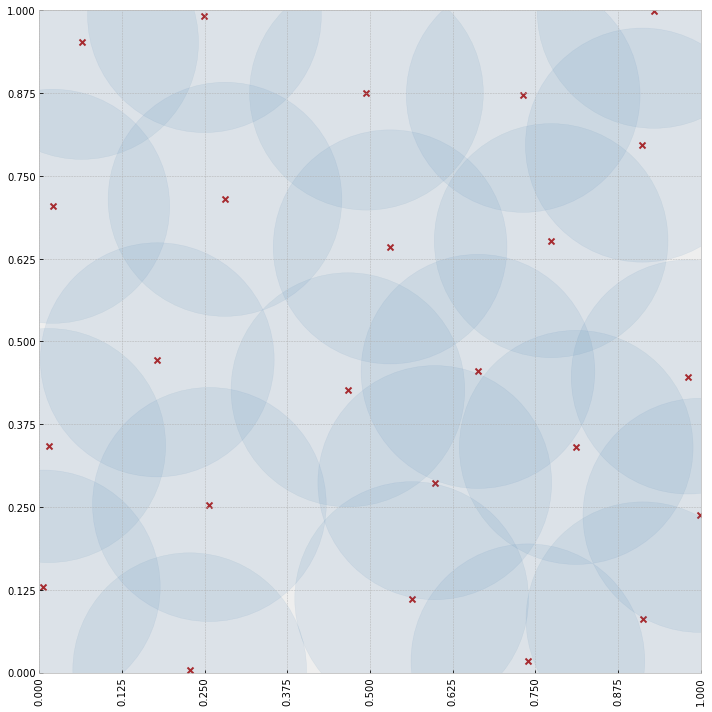

In [ ]:
n = 24
x_range = (0, 1)
y_range = (0, 1)

ax = plt.gca()

*points, radius = list(poisson_disk(x_range, y_range, n))

for point in points:
    plt.scatter(*point, color="firebrick", marker="x")
    circle = plt.Circle(point, radius, color="steelblue", alpha=0.1)
    ax.add_artist(circle)

plt.xlim(*x_range)
plt.ylim(*y_range)

divisions = sum(x_range) / (radius / 2 ** 0.5) + 1

plt.xticks(np.linspace(*x_range, int(divisions)), rotation=90)
plt.yticks(np.linspace(*y_range, int(divisions)))
plt.tight_layout()
plt.show()

In [ ]:
#export test
def test_poisson_disk_with_seed():
    from prosamplers.core import poisson_disk
    import numpy as np
    generator = poisson_disk(x_range=[0, 1], y_range=[0, 1], seed=42)
    assert list(np.round(next(generator), 2)) == [0.77, 0.65]
    assert list(np.round(next(generator), 2)) == [0.23, 0.0]
    assert list(np.round(next(generator), 2)) == [0.06, 0.95]
    assert list(np.round(next(generator), 2)) == [0.91, 0.08]
    assert list(np.round(next(generator), 2)) == [0.47, 0.43]


def test_poisson_disk_default_n():
    from prosamplers.core import poisson_disk
    assert list(poisson_disk(x_range=[0, 1], y_range=[0, 1]))

    
def test_poisson_disk_default_load_test():
    from prosamplers.core import poisson_disk
    from collections import deque
    
    deque(poisson_disk(x_range=[0, 1], y_range=[0, 1], n=1000), maxlen=0)
    assert True

# CCVT Sampling

# Quasi Monte Carlo - Low Discrepancy Sequences

- Van der Corput Sequence
- Sobol Sequence
- Halton Sequence
- Hammersley 


# Tree-structured Parzen estimator (TPE)

# Covariance matrix adaptation evolution strategy (CMA-ES)

# Presentation

In [ ]:
# n = 25
# x_range = (0, 1)
# y_range = (0, 1)

# methods = 10
# base_width = 5 * methods // 2
# fig, axes = plt.subplots(2, methods//2, figsize=(base_width, base_width/2))
# axes = np.ndarray.flatten(axes)


# ax = axes[0]

# for point in grid_search(x_range, y_range, n):
#     ax.scatter(*point, color="firebrick", marker="x")

# ax.set_xticks(np.linspace(*x_range, int(n**0.5)))
# ax.set_yticks(np.linspace(*y_range, int(n**0.5)))
    
# ax.set_xlim(*x_range)
# ax.set_ylim(*y_range)
# ax.set_title("Grid Search")



# ax = axes[1]

# for point in random_search(x_range, y_range, n):
#     ax.scatter(*point, color="firebrick", marker="x")

# ax.set_xlim(*x_range)
# ax.set_ylim(*y_range)
# ax.set_title("Random Search")


# ax = axes[2]

# for point in latin_hyper_cube(x_range, y_range, n):
#     ax.scatter(*point, color="firebrick", marker="x", s=15)

# ax.set_xlim(*x_range)
# ax.set_ylim(*y_range)

# divisions = 2**(n-1).bit_length() + 1

# for i in np.linspace(*x_range, divisions):
#     ax.axvline(i, alpha=0.6, ls="--", lw=1)

# for i in np.linspace(*y_range, divisions):
#     ax.axhline(i, alpha=0.6, ls="--", lw=1)

# # ax.set_xticks(np.linspace(*x_range, divisions))
# # ax.set_yticks(np.linspace(*y_range, divisions))

# ax.grid()
# ax.set_title("Latin Hypercube Sampling (N-Rooks)")


# ax = axes[3]


# ax.set_title("Orthogonal Sampling")


# ax = axes[4]
# for point in jittered_sampling(x_range, y_range, n):
#     ax.scatter(*point, color="firebrick", marker="x")



# divisions = int(2**np.ceil(np.log(n) / np.log(4)) + 1)

# for i in np.linspace(*x_range, divisions):
#     ax.axvline(i, alpha=0.6, ls="--", lw=1)

# for i in np.linspace(*y_range, divisions):
#     ax.axhline(i, alpha=0.6, ls="--", lw=1)

# ax.set_xlim(*x_range)
# ax.set_ylim(*y_range)

# ax.grid()

# ax.set_title("Stratified sampling (Jittered Sampling)")



# ax = axes[5]

# ax.set_title("Multi-Jittered")


# ax = axes[6]

# *points, radius = list(poisson_disk(x_range, y_range, n))

# for point in points:
#     ax.scatter(*point, color="firebrick", marker="x")
#     circle = plt.Circle(point, radius, color="steelblue", alpha=0.1)
#     ax.add_artist(circle)

# ax.set_xlim(*x_range)
# ax.set_ylim(*y_range)

# divisions = int(sum(x_range) / (radius / 2 ** 0.5) + 1)

# ax.set_xticks(np.linspace(*x_range, divisions))
# ax.set_yticks(np.linspace(*y_range, divisions))

# ax.set_title("Poisson Disk Sampling (Blue Noise)")


# ax = axes[7]

# ax.set_title("Quasi Monte-Carlo")


# plt.suptitle(f"Progressive Sampling Methods - N={n}", fontsize=18)
# plt.tight_layout()
# plt.subplots_adjust(top=0.9)
# plt.savefig("sampling_methods.png")
# plt.show()

# References

- https://cs.dartmouth.edu/~wjarosz/publications/subr16fourier-slides-2-patterns.pdf
- http://web.cs.wpi.edu/~emmanuel/courses/cs563/S10/talks/wk3_p1_wadii_sampling_techniques.pdf
- https://www.scratchapixel.com/lessons/mathematics-physics-for-computer-graphics/monte-carlo-methods-in-practice/introduction-quasi-monte-carlo

# Export

In [ ]:
#hide
from nbdev.export import *
notebook2script()

Converted 00_core.ipynb.
Converted 99_test.ipynb.
Converted index.ipynb.
